### Configurable Variables
Variables that can be modified in this notebook or None
- `qval` - qvalue threshold to filter SVGs or None
- `fsv` - FSV threshold to filter SVGs
- `input_data` — path to the input folder containing the dataset
- `supress_warnings` — boolean flag to enable/disable warning messages (`True`/`False`)
---
**Set following variables if you are running notebook interactively.**

In [555]:
qval_default = 0.05
fsv_default = 0.8
input_path_folder_default = "somde_results/SN124_A938797_Rep2/"
suppress_warnings_default = False

### Load variables from CMD

In [556]:
SUPPRESS_WARNINGS = None
try:
    if suppress_warnings == "True":
        SUPPRESS_WARNINGS = True
    else:
        SUPPRESS_WARNINGS = False
except NameError:
    SUPPRESS_WARNINGS = suppress_warnings_default

try:
    QVAL_TH = qval
except NameError:
    QVAL_TH = qval_default

try:
    FSV_TH = fsv
except NameError:
    FSV_TH = fsv_default

## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.
* Comment out the line below if warnings are desired for debugging.

In [557]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [558]:
!pip install matplotlib pandas numpy seaborn matplotlib_venn --quiet
%matplotlib inline


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


2. Import necessary libraries:

In [559]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import sys
import os
from sklearn.preprocessing import MinMaxScaler

3. load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.

In [560]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [561]:
# OPTION 2
DATA_PATH = None
try:
    DATA_PATH = input_data_folder
except NameError:
    DATA_PATH = input_path_folder_default

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: Datapath (", DATA_PATH ,") not found.")
    sys.exit()

print("Using input path:", DATA_PATH)

DATA_FOLDER_NAME = DATA_PATH.split("/")[-2].strip()
output_dir = os.path.join("figures/show/method_comparison/" + DATA_FOLDER_NAME)
os.makedirs(output_dir, exist_ok=True)

os.makedirs("method_comparison/" + DATA_FOLDER_NAME, exist_ok=True)

Using input path: somde_results/SN124_A938797_Rep2/


### Load data

In [562]:
somde_res = pd.read_csv("somde_results/" + DATA_FOLDER_NAME + "/somde_result.csv")
spatialde_res = pd.read_csv("spatialde_results/" + DATA_FOLDER_NAME + "/results.csv")

### Normalize data

In [563]:
# Concatenate FSVs to compute a global min-max scaling
all_fsv = pd.concat([somde_res['FSV'], spatialde_res['FSV']], axis=0).values.reshape(-1,1)

# Apply Min-Max normalization
scaler = MinMaxScaler(feature_range=(0,1))
all_fsv_norm = scaler.fit_transform(all_fsv).flatten()

# Split back normalized FSVs
somde_res['FSV_norm'] = all_fsv_norm[:len(somde_res)]
spatialde_res['FSV_norm'] = all_fsv_norm[len(somde_res):]

# Now you can use FSV_norm for thresholding and comparison
qval_default = 0.05
fsv_default = 0.8

somde_selected = somde_res[(somde_res['qval'] < qval_default) & (somde_res['FSV_norm'] > fsv_default)]
spatialde_selected = spatialde_res[(spatialde_res['qval'] < qval_default) & (spatialde_res['FSV_norm'] > fsv_default)]

print("SOMDE selected genes:", len(somde_selected))
print("SpatialDE selected genes:", len(spatialde_selected))

SOMDE selected genes: 232
SpatialDE selected genes: 53


### Select spatially variable genes
Filter by your dataset

In [564]:
if FSV_TH is None:
    FSV_TH = 0
if QVAL_TH is None:
    QVAL_TH = 1


somde_sig = somde_res[(somde_res["qval"] <= QVAL_TH) & (somde_res["FSV_norm"] >= FSV_TH)]["g"]
spatialde_sig = spatialde_res[(spatialde_res["qval"] <= QVAL_TH) & (spatialde_res["FSV_norm"] >= FSV_TH)]["g"]

set_somde = set(somde_sig)
set_spatialde = set(spatialde_sig)

print("SOMDE number of spatially variable genes: ", len(set_somde))
print("SPATIALDE number of spatially variable genes: ", len(set_spatialde))

SOMDE number of spatially variable genes:  232
SPATIALDE number of spatially variable genes:  53


# Method comparison plots - SVGs

### Venn diagram

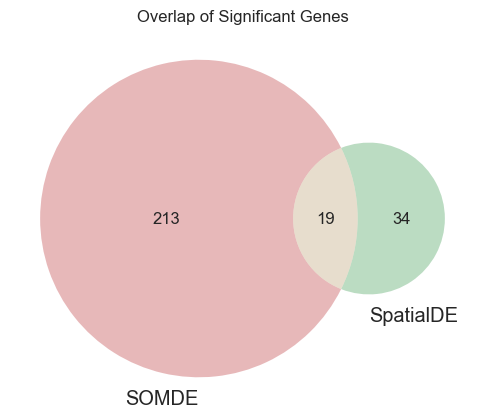

Venn diagram counts saved tomethod_comparison/SN124_A938797_Rep2/venn_counts.csv


In [565]:
plt.figure(figsize=(6, 6))
venn2([set_somde, set_spatialde], set_labels=("SOMDE", "SpatialDE"))
plt.title("Overlap of Significant Genes")
plt.savefig("figures/show/method_comparison/" + DATA_FOLDER_NAME + "/venn_diagram.png", dpi=300, bbox_inches='tight')
plt.show()

only_somde = set_somde - set_spatialde
only_spatialde = set_spatialde - set_somde
both = set_somde & set_spatialde
venn_df = pd.DataFrame({
    "Category": ["Only SOMDE", "Only SpatialDE", "Both"],
    "Count": [len(only_somde), len(only_spatialde), len(both)]
})
venn_df.to_csv("method_comparison/" + DATA_FOLDER_NAME + "/venn_counts.csv", index=False)
print("Venn diagram counts saved to" + "method_comparison/" + DATA_FOLDER_NAME + "/venn_counts.csv")

### Scatter Plot

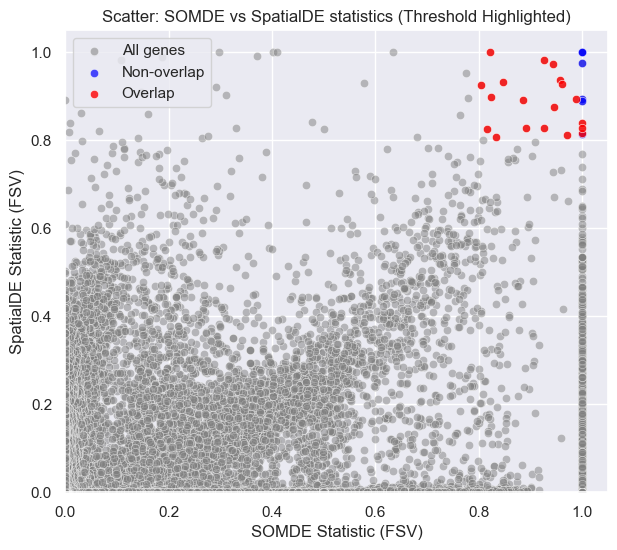

In [566]:
# Merge results and compute overlap
merged = pd.merge(somde_res, spatialde_res, on="g", suffixes=("_somde", "_spatialde"))
merged["overlap"] = merged["g"].isin(set_somde & set_spatialde)

# Filter by thresholds
merged_filtered = merged[
    (merged["FSV_norm_somde"] >= FSV_TH) &
    (merged["FSV_norm_spatialde"] >= FSV_TH)
]

plt.figure(figsize=(7, 6))

# Plot all_requirements points lightly in the background
sns.scatterplot(
    data=merged,
    x="FSV_norm_somde",
    y="FSV_norm_spatialde",
    color="gray",
    alpha=0.5,
    label="All genes"
)

# Highlight non-overlap points (blue)
sns.scatterplot(
    data=merged_filtered[merged_filtered["overlap"] == False],
    x="FSV_norm_somde",
    y="FSV_norm_spatialde",
    color="blue",
    alpha=0.7,
    label="Non-overlap"
)

# Highlight overlap points (gray/red)
sns.scatterplot(
    data=merged_filtered[merged_filtered["overlap"] == True],
    x="FSV_norm_somde",
    y="FSV_norm_spatialde",
    color="red",
    alpha=0.8,
    label="Overlap"
)

plt.title("Scatter: SOMDE vs SpatialDE statistics (Threshold Highlighted)")
plt.xlabel("SOMDE Statistic (FSV)")
plt.ylabel("SpatialDE Statistic (FSV)")
plt.legend()

plt.xlim(0, merged["FSV_norm_somde"].max()*1.05)  # optional: extend a bit beyond max
plt.ylim(0, merged["FSV_norm_spatialde"].max()*1.05)

plt.savefig(f"figures/show/method_comparison/{DATA_FOLDER_NAME}/scatter.overlap.fsv.png",
            dpi=300, bbox_inches='tight')
plt.show()


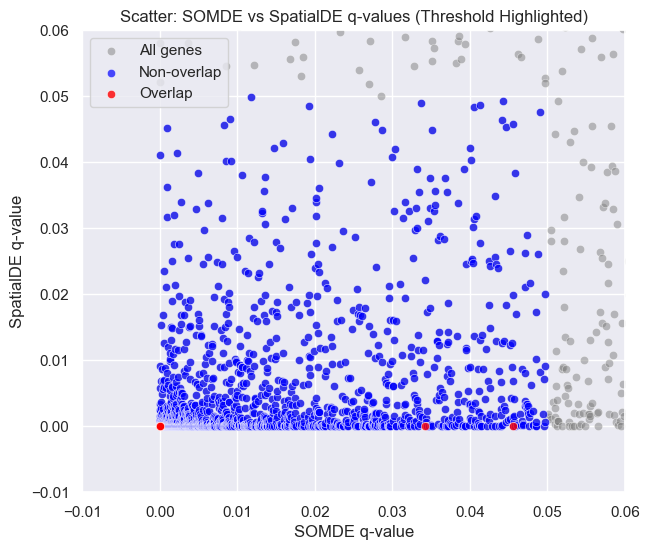

In [567]:
# Merge results and compute overlap
merged = pd.merge(somde_res, spatialde_res, on="g", suffixes=("_somde", "_spatialde"))
merged["overlap"] = merged["g"].isin(set_somde & set_spatialde)

# Filter by q-value thresholds
merged_filtered = merged[
    (merged["qval_somde"] <= QVAL_TH) &
    (merged["qval_spatialde"] <= QVAL_TH)
]

plt.figure(figsize=(7, 6))

# Plot all_requirements points lightly in the background
sns.scatterplot(
    data=merged,
    x="qval_somde",
    y="qval_spatialde",
    color="gray",
    alpha=0.5,
    label="All genes"
)

# Highlight non-overlap points (blue)
sns.scatterplot(
    data=merged_filtered[merged_filtered["overlap"] == False],
    x="qval_somde",
    y="qval_spatialde",
    color="blue",
    alpha=0.7,
    label="Non-overlap"
)

# Highlight overlap points (red)
sns.scatterplot(
    data=merged_filtered[merged_filtered["overlap"] == True],
    x="qval_somde",
    y="qval_spatialde",
    color="red",
    alpha=0.8,
    label="Overlap"
)

plt.title("Scatter: SOMDE vs SpatialDE q-values (Threshold Highlighted)")
plt.xlabel("SOMDE q-value")
plt.ylabel("SpatialDE q-value")
plt.legend()

plt.xlim(-0.01, 0.06)
plt.ylim(-0.01, 0.06)

plt.savefig(f"figures/show/method_comparison/{DATA_FOLDER_NAME}/scatter.overlap.qval.png",
            dpi=300, bbox_inches='tight')
plt.show()


In [568]:
def classify_gene_thresholded_FSV(row):
    if row["FSV_norm_somde"] >= FSV_TH and row["qval_somde"] <= QVAL_TH and \
       row["FSV_norm_spatialde"] < FSV_TH:
        return "Only SOMDE"
    elif row["FSV_norm_spatialde"] >= FSV_TH and row["qval_spatialde"] <= QVAL_TH and \
         row["FSV_norm_somde"] < FSV_TH:
        return "Only SpatialDE"
    elif row["FSV_norm_somde"] >= FSV_TH and row["qval_somde"] <= QVAL_TH and \
         row["FSV_norm_spatialde"] >= FSV_TH and row["qval_spatialde"] <= QVAL_TH:
        return "Both"
    else:
        return "None"

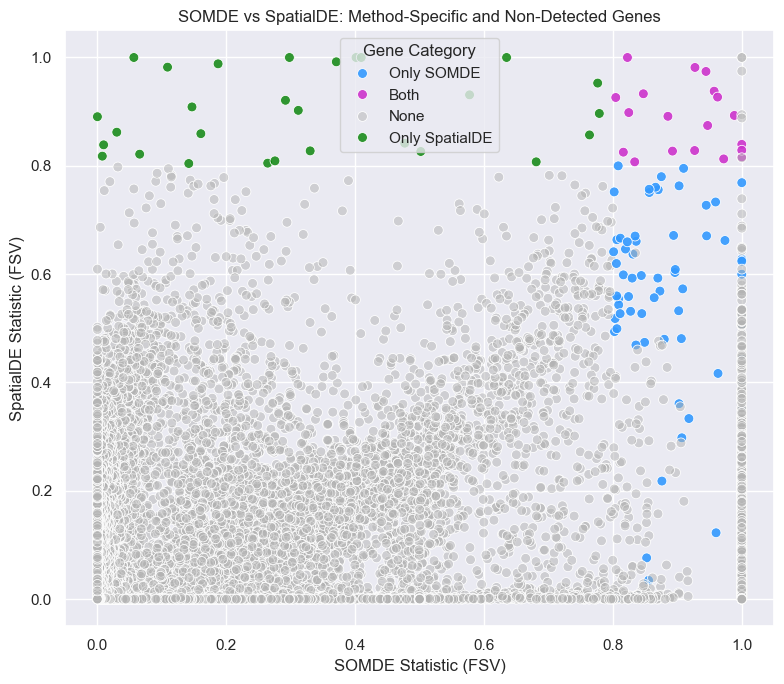

In [569]:
merged["category"] = merged.apply(classify_gene_thresholded_FSV, axis=1)

# Keep only 3 categories (exclude None if desired)
plot_data = merged[merged["category"].notna()]

plt.figure(figsize=(8, 7))


palette = {
    "Only SOMDE": (0.2, 0.6, 1.0, 0.9),      # blue
    "Only SpatialDE": (0.0, 0.5, 0.0, 0.8),  # green
    "Both": (0.8, 0.2, 0.8, 0.9),            # purple
    "None": (0.7, 0.7, 0.7, 0.5)             # transparent gray
}

sns.scatterplot(
    data=plot_data,
    x="FSV_norm_somde",
    y="FSV_norm_spatialde",
    hue="category",
    palette=palette,
    s=50
)

plt.title("SOMDE vs SpatialDE: Method-Specific and Non-Detected Genes")
plt.xlabel("SOMDE Statistic (FSV)")
plt.ylabel("SpatialDE Statistic (FSV)")
plt.legend(title="Gene Category")
plt.tight_layout()
plt.savefig(f"figures/show/method_comparison/{DATA_FOLDER_NAME}/scatter.somde_vs_spatialde.fsv.png",
            dpi=300, bbox_inches='tight')
plt.show()

In [570]:
# Assign categories based on q-value thresholds
def classify_gene_qval(row):
    if row["qval_somde"] <= QVAL_TH and row["qval_spatialde"] > QVAL_TH:
        return "Only SOMDE"
    elif row["qval_spatialde"] <= QVAL_TH and row["qval_somde"] > QVAL_TH:
        return "Only SpatialDE"
    elif row["qval_somde"] <= QVAL_TH and row["qval_spatialde"] <= QVAL_TH:
        return "Both"
    else:
        return "None"

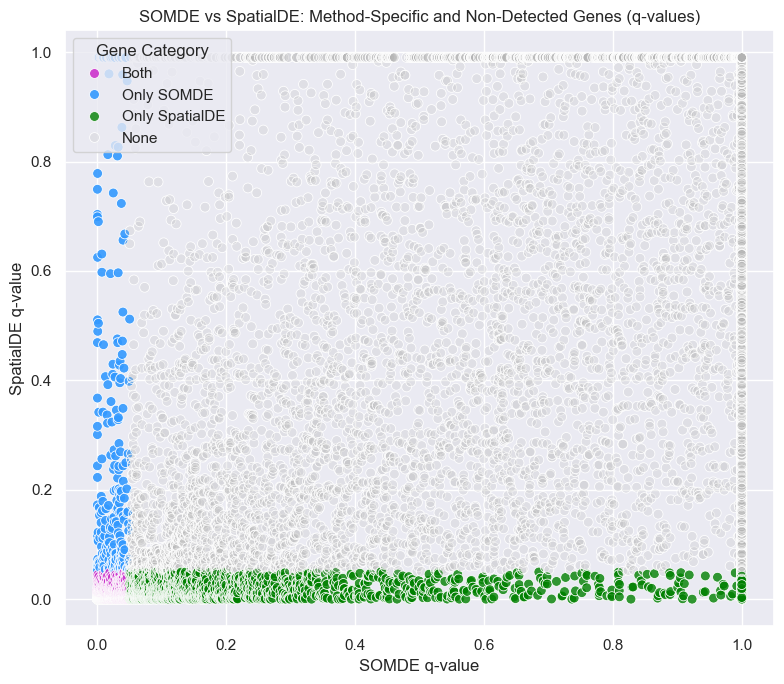

In [571]:
merged["category"] = merged.apply(classify_gene_qval, axis=1)

# Keep only points with a category
plot_data = merged[merged["category"].notna()]

plt.figure(figsize=(8, 7))

palette = {
    "Only SOMDE": (0.2, 0.6, 1.0, 0.9),      # blue
    "Only SpatialDE": (0.0, 0.5, 0.0, 0.8),  # green
    "Both": (0.8, 0.2, 0.8, 0.9),            # purple
    "None": (0.7, 0.7, 0.7, 0.2)             # transparent gray
}

sns.scatterplot(
    data=plot_data,
    x="qval_somde",
    y="qval_spatialde",
    hue="category",
    palette=palette,
    s=50
)

plt.title("SOMDE vs SpatialDE: Method-Specific and Non-Detected Genes (q-values)")
plt.xlabel("SOMDE q-value")
plt.ylabel("SpatialDE q-value")
plt.legend(title="Gene Category")
plt.tight_layout()
plt.savefig(f"figures/show/method_comparison/{DATA_FOLDER_NAME}/scatter.somde_vs_spatialde.qval.png",
            dpi=300, bbox_inches='tight')
plt.show()